In [ ]:
!pip install statsmodels

In [62]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error


from statsmodels.tsa.holtwinters import ExponentialSmoothing


std_noise 10.670843815750201


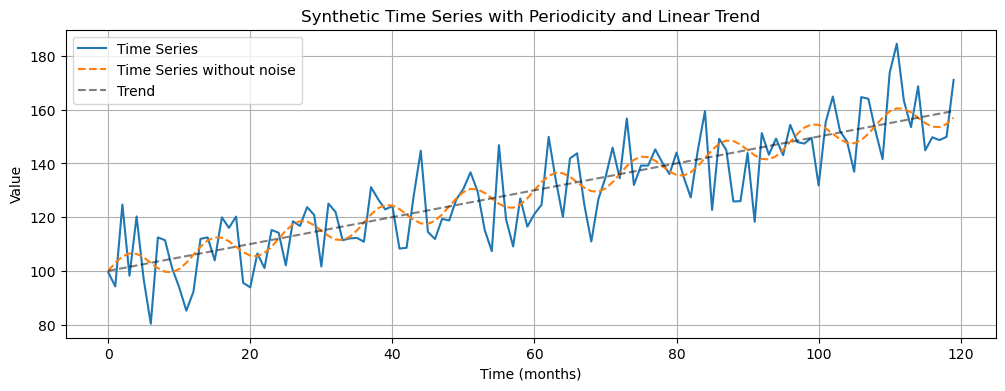

In [63]:


#CREATE A PERIOD TIME SERIES WITH LINEAR TREND
# Parameters
years = 10
period = 12   # periodicity (e.g., annual seasonality with monthly data)
n_points = years * period

# Time axis
t = np.arange(n_points)

start_value=100

# Components
trend_slope=0.5
trend = start_value+trend_slope* t                               # linear trend
#seasonal = 5 * np.sin(2 * np.pi * t / period) + 10 * np.sin(2 * np.pi * t / (period/2)) + 10 * np.sin(2 * np.pi * t / (period/4))# periodic component
seasonal = 5 * np.sin(2 * np.pi * t / period) # periodic component

standard_dev=10  #THIS MEANS YOU CANNOT HAVE BETTER RMSE THAN 10, WHICH OCCUR IF/WHEN THE TRUE DETERMINISTIC 
                 #PART HAS BEEN FOUND
noise = np.random.normal(scale=standard_dev, size=n_points)  # optional noise

std_noise=np.std(noise)
print("std_noise",std_noise)

# Final time series
x_without_noise=trend + seasonal
x = x_without_noise + noise


# Plot
plt.figure(figsize=(12, 4))
plt.plot(t, x, label='Time Series')
plt.plot(t, x_without_noise, label='Time Series without noise',linestyle = 'dashed')
plt.plot(t, trend, 'k--', alpha=0.5, label='Trend')
plt.title('Synthetic Time Series with Periodicity and Linear Trend')
plt.xlabel('Time (months)')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

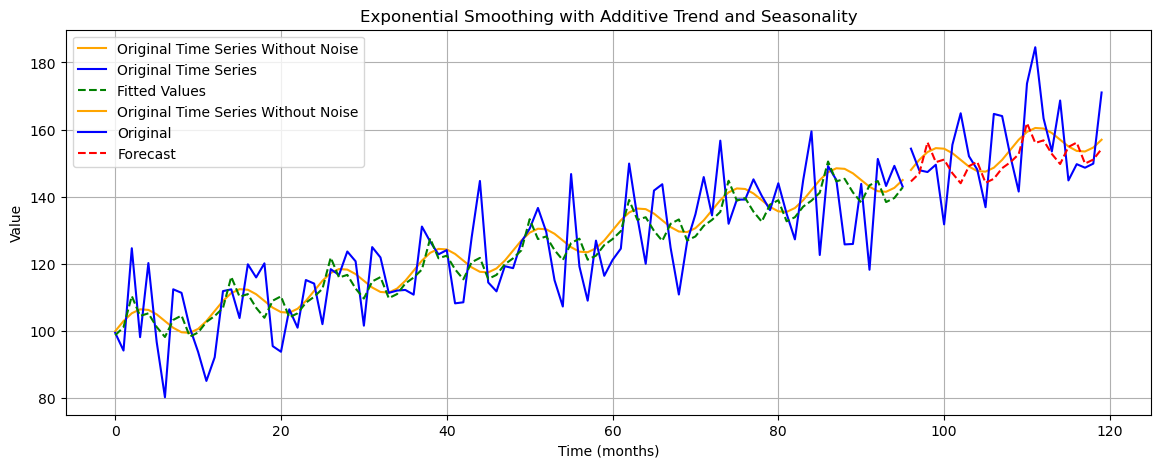

In [64]:

# EXAMPLE RESULT

x_history=x[:n_points-2*period]
t_history=t[:n_points-2*period]

x_without_noise_history=x_without_noise[:n_points-2*period]

n_points_history=n_points-2*period

x_future=x[n_points-2*period:]
x_without_noise_future=x_without_noise[n_points-2*period:]

# Step 2: Fit Exponential Smoothing with trend and seasonality
model = ExponentialSmoothing(
    x_history,
    trend='add',             # additive trend
    seasonal='add',          # additive seasonality
    seasonal_periods=period, # known seasonal length
)
fit = model.fit()

# Step 3: Forecast the next 12 months
forecast_steps = 2*period
forecast = fit.forecast(forecast_steps)

# Step 4: Plot original + forecast
plt.figure(figsize=(14, 5))
plt.plot(t_history, x_without_noise_history, label='Original Time Series Without Noise',color='orange',linestyle ='solid')
plt.plot(t_history, x_history, label='Original Time Series',color='blue')
plt.plot(t_history, fit.fittedvalues, label='Fitted Values', color='green',linestyle ='dashed')
plt.plot(np.arange(n_points_history, n_points_history+ forecast_steps), x_without_noise_future, label='Original Time Series Without Noise',color='orange',linestyle ='solid')
plt.plot(np.arange(n_points_history, n_points_history+ forecast_steps), x_future, label='Original', color='blue')
plt.plot(np.arange(n_points_history, n_points_history+ forecast_steps), forecast, label='Forecast', color='red',linestyle = 'dashed')
plt.title('Exponential Smoothing with Additive Trend and Seasonality')
plt.xlabel('Time (months)')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [65]:
# EXAMPLE RESULT
fitted_values = fit.fittedvalues
train_rmse = np.sqrt(mean_squared_error(x_history, fitted_values))
forecast_rmse = np.sqrt(mean_squared_error(x_future, forecast))
print(f"Training RMSE: {train_rmse:.2f}")
print(f"Forecast RMSE: {forecast_rmse:.4f}")


print(f"AIC: {fit.aic:.2f}")
print(f"BIC: {fit.bic:.2f}")

Training RMSE: 10.09
Forecast RMSE: 12.3119
AIC: 475.84
BIC: 516.87


In [66]:
# In R one can define a vector of ETS (Error, Trend, Seasonality) model names — including 
# damped and undamped variants. These strings follow the ETS notation where:
# First letter = Error type (A = additive, M = multiplicative)
# Second letter = Trend type (N = none, A = additive, M = multiplicative)
# Third letter = Seasonality type (N, A, or M)
#
# statsmodels.tsa.holtwinters.ExponentialSmoothing does not accept model types as combined 
# strings like "AAA" directly. Instead, you need to specify:
#
# trend: 'add', 'mul', or None
# seasonal: 'add', 'mul', or None
# seasonal_periods: required if seasonal is not None
# damped_trend: optional boolean flag
# So we need to parse each model string and map each character to the correct argument values.


 
    
# Define ETS model strings
#models_all = [
#    "ANN", "ANA", "ANM", "MNN", "MNA", "MNM",
#    "AAN", "AAA", "AAM", "MAN", "MAA", "MAM",
#    "AMN", "AMA", "AMM", "MMN", "MMA", "MMM"
#]

models_all = [
    "ANN", "ANA", "ANM", 
    "AAN", "AAA", "AAM", 
    "AMN", "AMA", "AMM", "MMN"
]
# Helper to convert ETS string to arguments
def parse_ets_string(ets_string):
    error = ets_string[0]  # Not used in statsmodels
    trend = ets_string[1]
    seasonal = ets_string[2]

    trend_map = {'N': None, 'A': 'add', 'M': 'mul'}
    seasonal_map = {'N': None, 'A': 'add', 'M': 'mul'}

    return trend_map[trend], seasonal_map[seasonal]


In [67]:


#FIT ALL MODELS AND RANK THEM FOR DIFFERENTLY LONG HISTORIES UNTIL PRESENT



result_list_rmse=[]
result_list_aicc=[]
result_list_bic=[]
result_list_combined=[]

for length_of_history_in_periods in range(4,years+1):

    x_tmp=x[n_points-length_of_history_in_periods*period:]
    n_points_tmp=len(x_tmp)
    x_history_tmp=x_tmp[:n_points_tmp-2*period]

    t_tmp=t[n_points-length_of_history_in_periods*period:]
    t_history_tmp=t_tmp[:n_points-2*period]
    n_points_history_tmp=n_points_tmp-2*period
    
    # Fit all models and evaluate
    results_rmse = []
    results_aicc = []
    results_bic = []
    results_forecast = []


    for model_name in models_all:
        trend, seasonal = parse_ets_string(model_name)
        try:
            model = ExponentialSmoothing(
                x_history_tmp,
                trend=trend,
                damped_trend=False,  # you can test True as well
                seasonal=seasonal,
                seasonal_periods=period if seasonal else None
            )
            fit = model.fit(optimized=True)
            fitted_vals = fit.fittedvalues
            rmse = np.sqrt(mean_squared_error(x_history_tmp, fitted_vals))

            forecast = fit.forecast(forecast_steps)
            forecast_rmse = np.sqrt(mean_squared_error(x_future, forecast))
        
            k = len(fit.params)  # includes smoothing parameters and initial states
            aicc = fit.aic + (2 * k * (k + 1)) / (n_points_history_tmp - k - 1)
               
            results_rmse.append((model_name, rmse))
            results_aicc.append((model_name, aicc))
            results_bic.append((model_name, fit.bic))
            results_forecast.append((model_name, forecast_rmse))
        except Exception as e:
            print(f"{model_name}: Failed to fit ({e})")

    # Sort by RMSE
    results_rmse.sort(key=lambda x: x[1])
    #print("\nTop 5 models by RMSE:")
    #for name, rmse in results_rmse[:1]:
    #    print(f"{name}: RMSE_train = {rmse:.2f}")

    # Sort by AICC
    results_aicc.sort(key=lambda x: x[1])
    #print("\nTop 5 models by AICC:")
    #for name, aicc in results_aicc[:1]:
    #    print(f"{name}: AICC = {aicc:.2f}")

    # Sort by BIC
    results_bic.sort(key=lambda x: x[1])
    #print("\nTop 5 models by BIC:")
    #for name, bic in results_bic[:1]:
    #    print(f"{name}: BIC= {bic:.2f}")

    # Sort by FORECAST
    results_forecast.sort(key=lambda x: x[1])
    #print("\nTop 5 models by FORECASTS:")
    #for name, rmse in results_forecast[:1]:
    #    print(f"{name}: rmse_forecast= {rmse:.2f}")

    result_list_rmse.append(results_rmse)
    result_list_aicc.append(results_aicc)
    result_list_bic.append(results_bic)
    
    result_list_combined.append([results_rmse[0][0],results_aicc[0][0],results_bic[0][0]])


/opt/anaconda3/envs/timeseries/lib/python3.13/site-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/opt/anaconda3/envs/timeseries/lib/python3.13/site-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/opt/anaconda3/envs/timeseries/lib/python3.13/site-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/opt/anaconda3/envs/timeseries/lib/python3.13/site-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/opt/anaconda3/envs/timeseries/lib/python3.13/site-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/opt/anaconda3/envs/timeseries/lib/python3.13/site-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  retur

In [68]:
result_list_combined

[['AMM', 'ANN', 'ANN'],
 ['AAA', 'ANN', 'ANN'],
 ['AAA', 'AAN', 'ANN'],
 ['AAA', 'AAN', 'AAN'],
 ['AAA', 'AAN', 'AAN'],
 ['AAA', 'AAN', 'AAN'],
 ['AAA', 'AAN', 'AAN']]

In [69]:
no_of_histories=len(result_list_combined)
no_of_histories

7

In [70]:
results_forecast

[('AMM', np.float64(11.583204295638632)),
 ('AMA', np.float64(11.691500986703087)),
 ('AMN', np.float64(11.707972420467689)),
 ('MMN', np.float64(11.707972420467689)),
 ('AAM', np.float64(12.254031381166126)),
 ('AAA', np.float64(12.311874237111125)),
 ('AAN', np.float64(12.374800712976066)),
 ('ANM', np.float64(17.879402168932515)),
 ('ANA', np.float64(18.12289276585729)),
 ('ANN', np.float64(18.908390711823113))]

In [71]:

# Convert to dictionary
results_forecast_dict = dict(results_forecast) 

RMSEs_forecast=np.zeros([no_of_histories,3])
for row in range(no_of_histories):
    for col in range(3):
        RMSEs_forecast[row,col]=results_forecast_dict[result_list_combined[row][col]]


RMSEs_forecast

array([[11.5832043 , 18.90839071, 18.90839071],
       [12.31187424, 18.90839071, 18.90839071],
       [12.31187424, 12.37480071, 18.90839071],
       [12.31187424, 12.37480071, 12.37480071],
       [12.31187424, 12.37480071, 12.37480071],
       [12.31187424, 12.37480071, 12.37480071],
       [12.31187424, 12.37480071, 12.37480071]])

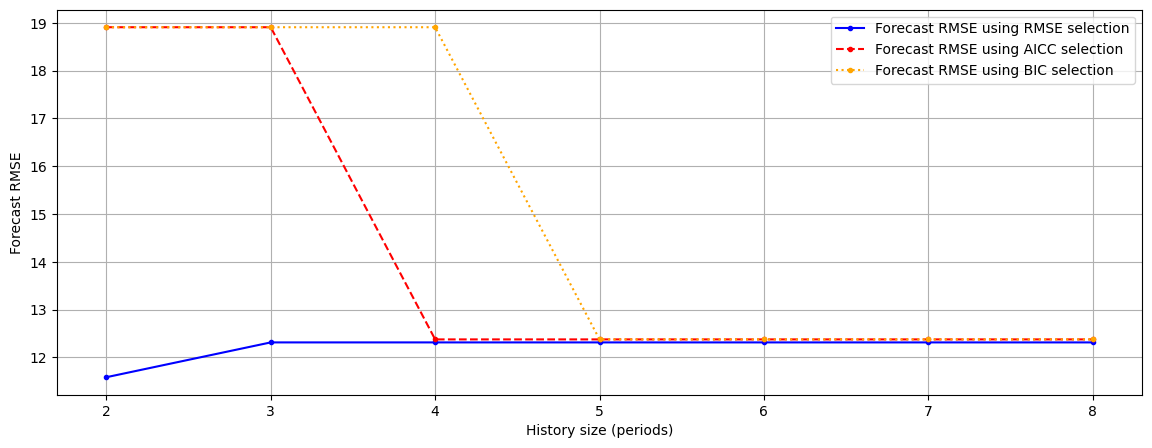

In [72]:
plt.figure(figsize=(14, 5))

time_forecast=range(2,2+no_of_histories)
plt.plot(time_forecast,RMSEs_forecast[:,0], label='Forecast RMSE using RMSE selection',color='blue',linestyle ='solid',marker='.')
plt.plot(time_forecast,RMSEs_forecast[:,1], label='Forecast RMSE using AICC selection',color='red',linestyle ='dashed',marker='.')
plt.plot(time_forecast,RMSEs_forecast[:,2], label='Forecast RMSE using BIC selection',color='orange',linestyle ='dotted',marker='.')
plt.xlabel('History size (periods)')
plt.ylabel('Forecast RMSE')
plt.legend()
plt.grid(True)
plt.show()

In [73]:
results_list=result_list_rmse

def compute_ranks(results):
    """Compute rank (1 = best) for each model in a list of (model, score) pairs."""
    sorted_res = sorted(results, key=lambda x: x[1])
    return {model: rank + 1 for rank, (model, _) in enumerate(sorted_res)}

# Compute all ranks
rank_dicts = [compute_ranks(res) for res in results_list]

# Get all unique models (assumed consistent across all result sets)
models = [model for model, _ in results_list[0]]

# Create final array with shape (num_models, num_metrics + 1)
# First column = model name, rest = ranks per metric
rank_array_rmse = np.array([
    [model] + [rank_dict[model] for rank_dict in rank_dicts]
    for model in models
], dtype=object)

# Print result
header = "Model " + "".join([f" | Len={i+2}  " for i in range(len(rank_dicts))])
print(header)
for row in rank_array_rmse:
    print(f"{row[0]:5} " + "".join([f" | {r:6} " for r in row[1:]]))

Model  | Len=2   | Len=3   | Len=4   | Len=5   | Len=6   | Len=7   | Len=8  
AMM    |      1  |      4  |      4  |      4  |      4  |      7  |      4 
AAM    |      2  |      2  |      2  |      3  |      3  |      2  |      3 
AMA    |      3  |      3  |      3  |      2  |      2  |      3  |      2 
AAA    |      4  |      1  |      1  |      1  |      1  |      1  |      1 
ANA    |      5  |      6  |      8  |      6  |      8  |      8  |      8 
ANM    |      6  |      5  |      9  |      7  |      9  |      9  |      9 
AMN    |      7  |      8  |      6  |      8  |      6  |      5  |      6 
MMN    |      8  |      9  |      7  |      9  |      7  |      6  |      7 
AAN    |      9  |      7  |      5  |      5  |      5  |      4  |      5 
ANN    |     10  |     10  |     10  |     10  |     10  |     10  |     10 


In [74]:
rank_array_rmse

array([['AMM', 1, 4, 4, 4, 4, 7, 4],
       ['AAM', 2, 2, 2, 3, 3, 2, 3],
       ['AMA', 3, 3, 3, 2, 2, 3, 2],
       ['AAA', 4, 1, 1, 1, 1, 1, 1],
       ['ANA', 5, 6, 8, 6, 8, 8, 8],
       ['ANM', 6, 5, 9, 7, 9, 9, 9],
       ['AMN', 7, 8, 6, 8, 6, 5, 6],
       ['MMN', 8, 9, 7, 9, 7, 6, 7],
       ['AAN', 9, 7, 5, 5, 5, 4, 5],
       ['ANN', 10, 10, 10, 10, 10, 10, 10]], dtype=object)

In [75]:
results_list=result_list_aicc

def compute_ranks(results):
    """Compute rank (1 = best) for each model in a list of (model, score) pairs."""
    sorted_res = sorted(results, key=lambda x: x[1])
    return {model: rank + 1 for rank, (model, _) in enumerate(sorted_res)}

# Compute all ranks
rank_dicts = [compute_ranks(res) for res in results_list]

# Get all unique models (assumed consistent across all result sets)
models = [model for model, _ in results_list[0]]

# Create final array with shape (num_models, num_metrics + 1)
# First column = model name, rest = ranks per metric
rank_array_aicc = np.array([
    [model] + [rank_dict[model] for rank_dict in rank_dicts]
    for model in models
], dtype=object)

# Print result
header = "Model " + "".join([f" | Len={i+2}  " for i in range(len(rank_dicts))])
print(header)
for row in rank_array_aicc:
    print(f"{row[0]:5} " + "".join([f" | {r:6} " for r in row[1:]]))

Model  | Len=2   | Len=3   | Len=4   | Len=5   | Len=6   | Len=7   | Len=8  
ANN    |      1  |      1  |      4  |      4  |      4  |      4  |      8 
AMN    |      2  |      3  |      2  |      2  |      2  |      2  |      2 
MMN    |      3  |      4  |      3  |      3  |      3  |      3  |      3 
AAN    |      4  |      2  |      1  |      1  |      1  |      1  |      1 
ANA    |      5  |     10  |      8  |      9  |      9  |      9  |      9 
ANM    |      6  |      9  |      9  |     10  |     10  |     10  |     10 
AMM    |      7  |      8  |     10  |      8  |      8  |      8  |      7 
AAM    |      8  |      6  |      6  |      7  |      7  |      6  |      6 
AMA    |      9  |      7  |      7  |      6  |      6  |      7  |      5 
AAA    |     10  |      5  |      5  |      5  |      5  |      5  |      4 


In [34]:
results_list=result_list_bic

def compute_ranks(results):
    """Compute rank (1 = best) for each model in a list of (model, score) pairs."""
    sorted_res = sorted(results, key=lambda x: x[1])
    return {model: rank + 1 for rank, (model, _) in enumerate(sorted_res)}

# Compute all ranks
rank_dicts = [compute_ranks(res) for res in results_list]

# Get all unique models (assumed consistent across all result sets)
models = [model for model, _ in results_list[0]]

# Create final array with shape (num_models, num_metrics + 1)
# First column = model name, rest = ranks per metric
rank_array_bic = np.array([
    [model] + [rank_dict[model] for rank_dict in rank_dicts]
    for model in models
], dtype=object)

# Print result
header = "Model " + "".join([f" | Len={i+2}  " for i in range(len(rank_dicts))])
print(header)
for row in rank_array_bic:
    print(f"{row[0]:5} " + "".join([f" | {r:6} " for r in row[1:]]))

Model  | Len=2   | Len=3   | Len=4   | Len=5   | Len=6   | Len=7   | Len=8  
ANN    |      1  |      1  |      4  |      4  |      4  |      4  |      4 
AMN    |      2  |      2  |      1  |      1  |      1  |      1  |      2 
MMN    |      3  |      3  |      2  |      2  |      2  |      2  |      3 
AAN    |      4  |      4  |      3  |      3  |      3  |      3  |      1 
AMA    |      5  |      5  |      6  |      5  |      5  |     10  |     10 
AAA    |      6  |     10  |      8  |      7  |      6  |      5  |      5 
AMM    |      7  |      8  |      5  |      6  |      7  |      9  |      7 
AAM    |      8  |      9  |      7  |      9  |      8  |      6  |      6 
ANM    |      9  |      7  |     10  |     10  |     10  |      8  |      9 
ANA    |     10  |      6  |      9  |      8  |      9  |      7  |      8 


In [35]:
rank_array_bic

array([['ANN', 1, 1, 4, 4, 4, 4, 4],
       ['AMN', 2, 2, 1, 1, 1, 1, 2],
       ['MMN', 3, 3, 2, 2, 2, 2, 3],
       ['AAN', 4, 4, 3, 3, 3, 3, 1],
       ['AMA', 5, 5, 6, 5, 5, 10, 10],
       ['AAA', 6, 10, 8, 7, 6, 5, 5],
       ['AMM', 7, 8, 5, 6, 7, 9, 7],
       ['AAM', 8, 9, 7, 9, 8, 6, 6],
       ['ANM', 9, 7, 10, 10, 10, 8, 9],
       ['ANA', 10, 6, 9, 8, 9, 7, 8]], dtype=object)

In [17]:
# PurgedKFold CV

In [57]:
def purged_kfold_cv_local(X, y=None, pred_times=None, eval_times=None, n_splits=10, n_test_splits=2, embargo_td=pd.Timedelta(minutes=0)):
    """
    Purged and embargoed combinatorial k-fold cross-validation.
    
    Parameters
    ----------
    X : pd.DataFrame or pd.Series
        Input data (time series).
    y : pd.Series, optional
        Response variable (same as X for ETS).
    pred_times : pd.Series
        Times at which predictions are made.
    eval_times : pd.Series
        Times at which responses are evaluated.
    n_splits : int, default=10
        Number of folds.
    n_test_splits : int, default=2
        Number of folds used in the test set.
    embargo_td : pd.Timedelta, default=0
        Embargo period to avoid train-test leakage.
    
    Yields
    ------
    train_indices : np.ndarray
        Indices for the training set.
    test_indices : np.ndarray
        Indices for the test set.
    """
    if not isinstance(X, (pd.DataFrame, pd.Series)):
        raise ValueError('X should be a pandas DataFrame/Series.')
    if y is not None and not isinstance(y, pd.Series):
        raise ValueError('y should be a pandas Series.')
    if not isinstance(pred_times, pd.Series):
        raise ValueError('pred_times should be a pandas Series.')
    if not isinstance(eval_times, pd.Series):
        raise ValueError('eval_times should be a pandas Series.')
    if y is not None and not (X.index.equals(y.index)):
        raise ValueError('X and y must have the same index')
    if not (X.index.equals(pred_times.index)):
        raise ValueError('X and pred_times must have the same index')
    if not (X.index.equals(eval_times.index)):
        raise ValueError('X and eval_times must have the same index')
    if not pred_times.equals(pred_times.sort_values()):
        raise ValueError('pred_times should be sorted')
    if not eval_times.equals(eval_times.sort_values()):
        raise ValueError('eval_times should be sorted')
    if not isinstance(n_splits, int) or n_splits <= 1:
        raise ValueError(f'n_splits must be an integer >= 2, got {n_splits}')
    if not isinstance(n_test_splits, int) or n_test_splits <= 0 or n_test_splits > n_splits - 1:
        raise ValueError(f'n_test_splits must be between 1 and n_splits-1, got {n_test_splits}')
    if not isinstance(embargo_td, pd.Timedelta) or embargo_td < pd.Timedelta(minutes=0):
        raise ValueError(f'embargo_td must be a positive Timedelta, got {embargo_td}')

    indices = np.arange(X.shape[0] if isinstance(X, pd.DataFrame) else len(X))
    
    fold_bounds = [(fold[0], fold[-1] + 1) for fold in np.array_split(indices, n_splits)]
    selected_fold_bounds = list(itt.combinations(fold_bounds, n_test_splits))
    selected_fold_bounds.reverse()

    for fold_bound_list in selected_fold_bounds:
        test_fold_bounds = []
        test_indices = np.empty(0, dtype=int)
        for fold_start, fold_end in fold_bound_list:
            if not test_fold_bounds or fold_start != test_fold_bounds[-1][-1]:
                test_fold_bounds.append((fold_start, fold_end))
            elif fold_start == test_fold_bounds[-1][-1]:
                test_fold_bounds[-1] = (test_fold_bounds[-1][0], fold_end)
            test_indices = np.union1d(test_indices, indices[fold_start:fold_end]).astype(int)

        train_indices = np.setdiff1d(indices, test_indices)
        for test_fold_start, test_fold_end in test_fold_bounds:
            time_test_fold_start = pred_times.iloc[test_fold_start]
            train_indices_1 = np.intersect1d(train_indices, indices[eval_times < time_test_fold_start])
            train_indices_2 = np.intersect1d(train_indices, indices[test_fold_end:])
            train_indices = np.concatenate((train_indices_1, train_indices_2))
            
            last_test_eval_time = eval_times.iloc[test_indices[test_indices <= test_fold_end]].max()
            min_train_index = len(pred_times[pred_times <= last_test_eval_time + embargo_td])
            if min_train_index < len(indices):
                allowed_indices = np.concatenate((indices[:test_fold_end], indices[min_train_index:]))
                train_indices = np.intersect1d(train_indices, allowed_indices)

        yield train_indices, test_indices

In [77]:
import pandas as pd
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
import itertools as itt

# Data generation
# Parameters
years = 10
period = 12  # Periodicity (e.g., annual seasonality with monthly data)
n_points = years * period
forecast_steps = 2 * period  # Forecast horizon (24 months)

# Time axis
t = np.arange(n_points)

start_value = 100

# Components
trend_slope = 0.5
trend = start_value + trend_slope * t  # Linear trend
seasonal = 5 * np.sin(2 * np.pi * t / period)  # Periodic component
standard_dev = 10
noise = np.random.normal(scale=standard_dev, size=n_points)

std_noise = np.std(noise)
print("std_noise:", std_noise)

# Final time series
x_without_noise = trend + seasonal
x = x_without_noise + noise

# Convert to pandas Series with datetime index
x = pd.Series(x, index=pd.date_range(start='2020-01-01', periods=n_points, freq='ME'))
t = x.index
y = x  # Response variable for ETS

# Define x_future (last 2 * period points)
x_future = x[-forecast_steps:].copy()

# Check for non-positive values
if (x <= 0).any():
    print("Warning: Data contains non-positive values. Shifting to ensure positivity for multiplicative models.")
    x = pd.Series(x - x.min() + 1, index=x.index)  # Preserve Series and index
    x_future = pd.Series(x_future - x_future.min() + 1, index=x_future.index)
    y = x

# Define purged k-fold CV function
def purged_kfold_cv_local(X, y=None, pred_times=None, eval_times=None, n_splits=10, n_test_splits=2, embargo_td=pd.Timedelta(minutes=0)):
    """
    Purged and embargoed combinatorial k-fold cross-validation.
    
    Parameters
    ----------
    X : pd.DataFrame or pd.Series
        Input data (time series).
    y : pd.Series, optional
        Response variable (same as X for ETS).
    pred_times : pd.Series
        Times at which predictions are made.
    eval_times : pd.Series
        Times at which responses are evaluated.
    n_splits : int, default=10
        Number of folds.
    n_test_splits : int, default=2
        Number of folds used in the test set.
    embargo_td : pd.Timedelta, default=0
        Embargo period to avoid train-test leakage.
    
    Yields
    ------
    train_indices : np.ndarray
        Indices for the training set.
    test_indices : np.ndarray
        Indices for the test set.
    """
    if not isinstance(X, (pd.DataFrame, pd.Series)):
        raise ValueError('X should be a pandas DataFrame/Series.')
    if y is not None and not isinstance(y, pd.Series):
        raise ValueError('y should be a pandas Series.')
    if not isinstance(pred_times, pd.Series):
        raise ValueError('pred_times should be a pandas Series.')
    if not isinstance(eval_times, pd.Series):
        raise ValueError('eval_times should be a pandas Series.')
    if y is not None and not (X.index.equals(y.index)):
        raise ValueError('X and y must have the same index')
    if not (X.index.equals(pred_times.index)):
        raise ValueError('X and pred_times must have the same index')
    if not (X.index.equals(eval_times.index)):
        raise ValueError('X and eval_times must have the same index')
    if not pred_times.equals(pred_times.sort_values()):
        raise ValueError('pred_times should be sorted')
    if not eval_times.equals(eval_times.sort_values()):
        raise ValueError('eval_times should be sorted')
    if not isinstance(n_splits, int) or n_splits <= 1:
        raise ValueError(f'n_splits must be an integer >= 2, got {n_splits}')
    if not isinstance(n_test_splits, int) or n_test_splits <= 0 or n_test_splits > n_splits - 1:
        raise ValueError(f'n_test_splits must be between 1 and n_splits-1, got {n_test_splits}')
    if not isinstance(embargo_td, pd.Timedelta) or embargo_td < pd.Timedelta(minutes=0):
        raise ValueError(f'embargo_td must be a positive Timedelta, got {embargo_td}')

    indices = np.arange(X.shape[0] if isinstance(X, pd.DataFrame) else len(X))
    
    fold_bounds = [(fold[0], fold[-1] + 1) for fold in np.array_split(indices, n_splits)]
    selected_fold_bounds = list(itt.combinations(fold_bounds, n_test_splits))
    selected_fold_bounds.reverse()

    for fold_bound_list in selected_fold_bounds:
        test_fold_bounds = []
        test_indices = np.empty(0, dtype=int)
        for fold_start, fold_end in fold_bound_list:
            if not test_fold_bounds or fold_start != test_fold_bounds[-1][-1]:
                test_fold_bounds.append((fold_start, fold_end))
            elif fold_start == test_fold_bounds[-1][-1]:
                test_fold_bounds[-1] = (test_fold_bounds[-1][0], fold_end)
            test_indices = np.union1d(test_indices, indices[fold_start:fold_end]).astype(int)

        train_indices = np.setdiff1d(indices, test_indices)
        for test_fold_start, test_fold_end in test_fold_bounds:
            time_test_fold_start = pred_times.iloc[test_fold_start]
            train_indices_1 = np.intersect1d(train_indices, indices[eval_times < time_test_fold_start])
            train_indices_2 = np.intersect1d(train_indices, indices[test_fold_end:])
            train_indices = np.concatenate((train_indices_1, train_indices_2))
            
            last_test_eval_time = eval_times.iloc[test_indices[test_indices <= test_fold_end]].max()
            min_train_index = len(pred_times[pred_times <= last_test_eval_time + embargo_td])
            if min_train_index < len(indices):
                allowed_indices = np.concatenate((indices[:test_fold_end], indices[min_train_index:]))
                train_indices = np.intersect1d(train_indices, allowed_indices)

        yield train_indices, test_indices

# Define ETS model strings
models_all = [
    "ANN", "ANA", "ANM",
    "AAN", "AAA", "AAM",
    "AMN", "AMA", "AMM", "MMN"
]

# Helper to parse ETS model strings for ExponentialSmoothing
def parse_ets_string(ets_string):
    error = ets_string[0]  # Not used in ExponentialSmoothing
    trend = ets_string[1]
    seasonal = ets_string[2]
    trend_map = {'N': None, 'A': 'add', 'M': 'mul'}
    seasonal_map = {'N': None, 'A': 'add', 'M': 'mul'}
    return error, trend_map[trend], seasonal_map[seasonal]

# Define pred_times and eval_times for CV
pred_times = pd.Series(x.index, index=x.index)  # Ensure same index as x
eval_times = pd.Series(x.index.shift(periods=forecast_steps, freq='ME')[:len(x)], index=x.index)

# Initialize CV
cv = purged_kfold_cv_local(
    X=x, y=y, pred_times=pred_times, eval_times=eval_times,
    n_splits=2, n_test_splits=2, embargo_td=pd.Timedelta(days=30)
)

# Lists to store results
result_list_rmse = []
result_list_aicc = []
result_list_bic = []
result_list_forecast = []
result_list_combined = []

# Perform cross-validation
for fold_idx, (train_indices, test_indices) in enumerate(cv):
    try:
        # Extract train and test data
        x_train = x.iloc[train_indices]
        x_test = x.iloc[test_indices]
        n_points_train = len(x_train)

        # Lists to store results for this fold
        results_rmse = []
        results_aicc = []
        results_bic = []
        results_forecast = []

        # Fit and evaluate each ETS model
        for model_name in models_all:
            try:
                error, trend, seasonal = parse_ets_string(model_name)
                # Initialize ExponentialSmoothing model
                model = ExponentialSmoothing(
                    x_train,
                    trend=trend,
                    seasonal=seasonal,
                    seasonal_periods=period if seasonal else None,
                    damped_trend=False
                )
                fit = model.fit(optimized=True, use_brute=True)
                
                # Calculate training RMSE
                fitted_vals = fit.fittedvalues
                rmse = np.sqrt(mean_squared_error(x_train, fitted_vals))
                
                # Forecast and calculate test RMSE
                forecast = fit.forecast(steps=forecast_steps)
                if len(forecast) > len(x_test):
                    forecast = forecast[:len(x_test)]
                elif len(forecast) < len(x_test):
                    x_test = x_test[:len(forecast)]
                forecast_rmse = np.sqrt(mean_squared_error(x_test, forecast))
                
                # Calculate AICC and BIC
                n_params = len(fit.params)
                log_likelihood = fit.llf
                aicc = -2 * log_likelihood + 2 * n_params + (2 * n_params * (n_params + 1)) / (n_points_train - n_params - 1)
                bic = -2 * log_likelihood + n_params * np.log(n_points_train)
                
                # Store results
                results_rmse.append((model_name, rmse))
                results_aicc.append((model_name, aicc))
                results_bic.append((model_name, bic))
                results_forecast.append((model_name, forecast_rmse))

            except Exception as e:
                print(f"Fold {fold_idx + 1}, Model {model_name}: Failed to fit ({e})")

        # Sort results by metrics
        results_rmse.sort(key=lambda x: x[1])
        results_aicc.sort(key=lambda x: x[1])
        results_bic.sort(key=lambda x: x[1])
        results_forecast.sort(key=lambda x: x[1])

        # Store results for this fold
        result_list_rmse.append(results_rmse)
        result_list_aicc.append(results_aicc)
        result_list_bic.append(results_bic)
        result_list_forecast.append(results_forecast)
        result_list_combined.append([results_rmse[0][0], results_aicc[0][0], results_bic[0][0]])

    except Exception as e:
        print(f"Fold {fold_idx + 1}: Error processing fold ({e})")



std_noise: 9.802462798214885


ValueError: n_test_splits must be between 1 and n_splits-1, got 2

In [47]:
import pandas as pd
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
import itertools as itt

# Data generation
# Parameters
years = 10
period = 12  # Periodicity (e.g., annual seasonality with monthly data)
n_points = years * period
forecast_steps = 2 * period  # Forecast horizon (24 months)

# Time axis
t = np.arange(n_points)

start_value = 100

# Components
trend_slope = 0.5
trend = start_value + trend_slope * t  # Linear trend
seasonal = 5 * np.sin(2 * np.pi * t / period)  # Periodic component
standard_dev = 10
noise = np.random.normal(scale=standard_dev, size=n_points)

std_noise = np.std(noise)
print("std_noise:", std_noise)

# Final time series
x_without_noise = trend + seasonal
x = x_without_noise + noise

# Convert to pandas Series with datetime index
x = pd.Series(x, index=pd.date_range(start='2020-01-01', periods=n_points, freq='ME'))
t = x.index
y = x  # Response variable for ETS

# Define x_future (last 2 * period points)
x_future = x[-forecast_steps:].copy()

# Check for non-positive values
if (x <= 0).any():
    print("Warning: Data contains non-positive values. Shifting to ensure positivity for multiplicative models.")
    x = pd.Series(x - x.min() + 1, index=x.index)  # Preserve Series and index
    x_future = pd.Series(x_future - x_future.min() + 1, index=x_future.index)
    y = x

# Define purged k-fold CV function
def purged_kfold_cv_local(X, y=None, pred_times=None, eval_times=None, n_splits=10, n_test_splits=2, embargo_td=pd.Timedelta(minutes=0)):
    """
    Purged and embargoed combinatorial k-fold cross-validation.
    
    Parameters
    ----------
    X : pd.DataFrame or pd.Series
        Input data (time series).
    y : pd.Series, optional
        Response variable (same as X for ETS).
    pred_times : pd.Series
        Times at which predictions are made.
    eval_times : pd.Series
        Times at which responses are evaluated.
    n_splits : int, default=10
        Number of folds.
    n_test_splits : int, default=2
        Number of folds used in the test set.
    embargo_td : pd.Timedelta, default=0
        Embargo period to avoid train-test leakage.
    
    Yields
    ------
    train_indices : np.ndarray
        Indices for the training set.
    test_indices : np.ndarray
        Indices for the test set.
    """
    if not isinstance(X, (pd.DataFrame, pd.Series)):
        raise ValueError('X should be a pandas DataFrame/Series.')
    if y is not None and not isinstance(y, pd.Series):
        raise ValueError('y should be a pandas Series.')
    if not isinstance(pred_times, pd.Series):
        raise ValueError('pred_times should be a pandas Series.')
    if not isinstance(eval_times, pd.Series):
        raise ValueError('eval_times should be a pandas Series.')
    if y is not None and not (X.index.equals(y.index)):
        raise ValueError('X and y must have the same index')
    if not (X.index.equals(pred_times.index)):
        raise ValueError('X and pred_times must have the same index')
    if not (X.index.equals(eval_times.index)):
        raise ValueError('X and eval_times must have the same index')
    if not pred_times.equals(pred_times.sort_values()):
        raise ValueError('pred_times should be sorted')
    if not eval_times.equals(eval_times.sort_values()):
        raise ValueError('eval_times should be sorted')
    if not isinstance(n_splits, int) or n_splits <= 1:
        raise ValueError(f'n_splits must be an integer >= 2, got {n_splits}')
    if not isinstance(n_test_splits, int) or n_test_splits <= 0 or n_test_splits > n_splits - 1:
        raise ValueError(f'n_test_splits must be between 1 and n_splits-1, got {n_test_splits}')
    if not isinstance(embargo_td, pd.Timedelta) or embargo_td < pd.Timedelta(minutes=0):
        raise ValueError(f'embargo_td must be a positive Timedelta, got {embargo_td}')

    indices = np.arange(X.shape[0] if isinstance(X, pd.DataFrame) else len(X))
    
    fold_bounds = [(fold[0], fold[-1] + 1) for fold in np.array_split(indices, n_splits)]
    selected_fold_bounds = list(itt.combinations(fold_bounds, n_test_splits))
    selected_fold_bounds.reverse()

    for fold_bound_list in selected_fold_bounds:
        test_fold_bounds = []
        test_indices = np.empty(0, dtype=int)
        for fold_start, fold_end in fold_bound_list:
            if not test_fold_bounds or fold_start != test_fold_bounds[-1][-1]:
                test_fold_bounds.append((fold_start, fold_end))
            elif fold_start == test_fold_bounds[-1][-1]:
                test_fold_bounds[-1] = (test_fold_bounds[-1][0], fold_end)
            test_indices = np.union1d(test_indices, indices[fold_start:fold_end]).astype(int)

        train_indices = np.setdiff1d(indices, test_indices)
        for test_fold_start, test_fold_end in test_fold_bounds:
            time_test_fold_start = pred_times.iloc[test_fold_start]
            train_indices_1 = np.intersect1d(train_indices, indices[eval_times < time_test_fold_start])
            train_indices_2 = np.intersect1d(train_indices, indices[test_fold_end:])
            train_indices = np.concatenate((train_indices_1, train_indices_2))
            
            last_test_eval_time = eval_times.iloc[test_indices[test_indices <= test_fold_end]].max()
            min_train_index = len(pred_times[pred_times <= last_test_eval_time + embargo_td])
            if min_train_index < len(indices):
                allowed_indices = np.concatenate((indices[:test_fold_end], indices[min_train_index:]))
                train_indices = np.intersect1d(train_indices, allowed_indices)

        yield train_indices, test_indices

# Define ETS model strings
models_all = [
    "ANN", "ANA", "ANM",
    "AAN", "AAA", "AAM",
    "AMN", "AMA", "AMM", "MMN"
]

# Helper to parse ETS model strings for ExponentialSmoothing
def parse_ets_string(ets_string):
    error = ets_string[0]  # Not used in ExponentialSmoothing
    trend = ets_string[1]
    seasonal = ets_string[2]
    trend_map = {'N': None, 'A': 'add', 'M': 'mul'}
    seasonal_map = {'N': None, 'A': 'add', 'M': 'mul'}
    return error, trend_map[trend], seasonal_map[seasonal]

# Define pred_times and eval_times for CV
pred_times = pd.Series(x.index, index=x.index)  # Ensure same index as x
eval_times = pd.Series(x.index.shift(periods=forecast_steps, freq='ME')[:len(x)], index=x.index)

# Initialize CV
cv = purged_kfold_cv_local(
    X=x, y=y, pred_times=pred_times, eval_times=eval_times,
    n_splits=10, n_test_splits=2, embargo_td=pd.Timedelta(days=30)
)

# Lists to store results
result_list_rmse = []
result_list_aicc = []
result_list_bic = []
result_list_forecast = []
result_list_combined = []

# Perform cross-validation
for fold_idx, (train_indices, test_indices) in enumerate(cv):
    try:
        # Extract train and test data
        x_train = x.iloc[train_indices]
        x_test = x.iloc[test_indices]
        n_points_train = len(x_train)

        # Lists to store results for this fold
        results_rmse = []
        results_aicc = []
        results_bic = []
        results_forecast = []

        # Fit and evaluate each ETS model
        for model_name in models_all:
            try:
                error, trend, seasonal = parse_ets_string(model_name)
                # Initialize ExponentialSmoothing model
                model = ExponentialSmoothing(
                    x_train,
                    trend=trend,
                    seasonal=seasonal,
                    seasonal_periods=period if seasonal else None,
                    damped_trend=False
                )
                fit = model.fit(optimized=True, use_brute=True)
                
                # Calculate training RMSE
                fitted_vals = fit.fittedvalues
                rmse = np.sqrt(mean_squared_error(x_train, fitted_vals))
                
                # Forecast and calculate test RMSE
                forecast = fit.forecast(steps=forecast_steps)
                if len(forecast) > len(x_test):
                    forecast = forecast[:len(x_test)]
                elif len(forecast) < len(x_test):
                    x_test = x_test[:len(forecast)]
                forecast_rmse = np.sqrt(mean_squared_error(x_test, forecast))
                
                # Calculate AICC and BIC using SSE-based log-likelihood
                n_params = len(fit.params)
                sse = fit.sse
                n_points_train = len(x_train)
                # Approximate log-likelihood assuming Gaussian errors
                log_likelihood = -n_points_train / 2 * (1 + np.log(2 * np.pi) + np.log(sse / n_points_train))
                aicc = -2 * log_likelihood + 2 * n_params + (2 * n_params * (n_params + 1)) / (n_points_train - n_params - 1)
                bic = -2 * log_likelihood + n_params * np.log(n_points_train)
                
                # Store results
                results_rmse.append((model_name, rmse))
                results_aicc.append((model_name, aicc))
                results_bic.append((model_name, bic))
                results_forecast.append((model_name, forecast_rmse))

            except Exception as e:
                print(f"Fold {fold_idx + 1}, Model {model_name}: Failed to fit ({e})")

        # Sort results by metrics
        results_rmse.sort(key=lambda x: x[1])
        results_aicc.sort(key=lambda x: x[1])
        results_bic.sort(key=lambda x: x[1])
        results_forecast.sort(key=lambda x: x[1])

        # Store results for this fold
        result_list_rmse.append(results_rmse)
        result_list_aicc.append(results_aicc)
        result_list_bic.append(results_bic)
        result_list_forecast.append(results_forecast)
        result_list_combined.append([results_rmse[0][0], results_aicc[0][0], results_bic[0][0]])

    except Exception as e:
        print(f"Fold {fold_idx + 1}: Error processing fold ({e})")

# Print results
print("\nResults by Fold:")
for i in range(len(result_list_combined)):
    print(f"\nFold {i + 1}")
    print(f"Best RMSE Model: {result_list_combined[i][0]}")
    print(f"Best AICC Model: {result_list_combined[i][1]}")
    print(f"Best BIC Model: {result_list_combined[i][2]}")
    print("\nTop 5 models by RMSE:")
    for name, rmse in result_list_rmse[i][:5]:
        print(f"{name}: RMSE_train = {rmse:.2f}")
    print("\nTop 5 models by AICC:")
    for name, aicc in result_list_aicc[i][:5]:
        print(f"{name}: AICC = {aicc:.2f}")
    print("\nTop 5 models by BIC:")
    for name, bic in result_list_bic[i][:5]:
        print(f"{name}: BIC = {bic:.2f}")
    print("\nTop 5 models by FORECAST RMSE:")
    for name, rmse in result_list_forecast[i][:5]:
        print(f"{name}: rmse_forecast = {rmse:.2f}")

std_noise: 9.545647029587954


/opt/anaconda3/envs/timeseries/lib/python3.13/site-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/opt/anaconda3/envs/timeseries/lib/python3.13/site-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/opt/anaconda3/envs/timeseries/lib/python3.13/site-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/opt/anaconda3/envs/timeseries/lib/python3.13/site-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/opt/anaconda3/envs/timeseries/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/timeseries/lib/python3.13/site-pac

Fold 25, Model ANA: Failed to fit (Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.)
Fold 25, Model ANM: Failed to fit (Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.)
Fold 25, Model AAA: Failed to fit (Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.)
Fold 25, Model AAM: Failed to fit (Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.)
Fold 25, Model AMA: Failed to fit (Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.)
Fold 25, Model AMM: Failed to fit (Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.)


/opt/anaconda3/envs/timeseries/lib/python3.13/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/opt/anaconda3/envs/timeseries/lib/python3.13/site-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/opt/anaconda3/envs/timeseries/lib/python3.13/site-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/opt/anaconda3/envs/timeseries/lib/python3.13/site-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/opt/anaconda3/envs/timeseries/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/timeseries/l

Fold 32, Model ANA: Failed to fit (Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.)
Fold 32, Model ANM: Failed to fit (Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.)
Fold 32, Model AAA: Failed to fit (Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.)
Fold 32, Model AAM: Failed to fit (Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.)
Fold 32, Model AMA: Failed to fit (Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.)
Fold 32, Model AMM: Failed to fit (Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.)


/opt/anaconda3/envs/timeseries/lib/python3.13/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/opt/anaconda3/envs/timeseries/lib/python3.13/site-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/opt/anaconda3/envs/timeseries/lib/python3.13/site-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/opt/anaconda3/envs/timeseries/lib/python3.13/site-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/opt/anaconda3/envs/timeseries/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/timeseries/l


Results by Fold:

Fold 1
Best RMSE Model: AAA
Best AICC Model: AAA
Best BIC Model: AAA

Top 5 models by RMSE:
AAA: RMSE_train = 9.28
AAM: RMSE_train = 9.29
AMA: RMSE_train = 9.30
AMM: RMSE_train = 9.31
ANM: RMSE_train = 9.45

Top 5 models by AICC:
AAA: AICC = 548.72
AAM: AICC = 548.90
AMA: AICC = 549.10
AMM: AICC = 549.26
ANM: AICC = 551.32

Top 5 models by BIC:
AAA: BIC = 567.88
AAM: BIC = 568.06
AMA: BIC = 568.26
AMM: BIC = 568.42
ANM: BIC = 570.48

Top 5 models by FORECAST RMSE:
AAN: rmse_forecast = 17.42
AMM: rmse_forecast = 17.43
AMA: rmse_forecast = 17.67
AAM: rmse_forecast = 17.90
AAA: rmse_forecast = 18.16

Fold 2
Best RMSE Model: AMA
Best AICC Model: AMA
Best BIC Model: AMA

Top 5 models by RMSE:
AMA: RMSE_train = 8.48
AMM: RMSE_train = 8.59
AAA: RMSE_train = 8.61
AAM: RMSE_train = 8.65
ANA: RMSE_train = 9.29

Top 5 models by AICC:
AMA: AICC = 451.25
AMM: AICC = 452.77
AAA: AICC = 453.08
AAM: AICC = 453.72
ANA: AICC = 462.28

Top 5 models by BIC:
AMA: BIC = 467.70
AMM: BIC = 

/opt/anaconda3/envs/timeseries/lib/python3.13/site-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


In [76]:
x

array([ 99.49157765,  94.22780398, 124.68850236,  98.20858156,
       120.27250829,  96.81425033,  80.32684682, 112.46152906,
       111.40670678, 101.02361182,  93.82067728,  85.18221755,
        92.21946686, 111.92038752, 112.4497942 , 103.90978734,
       119.90644742, 115.99799609, 120.19339998,  95.54084366,
        93.86577212, 106.49814592, 101.03213409, 115.23054836,
       114.16789633, 102.07927774, 118.45642332, 116.7211071 ,
       123.71688812, 120.79772347, 101.63650976, 125.02847975,
       121.95138719, 111.39696562, 112.08444202, 112.26838215,
       110.86946661, 131.14222739, 126.65224832, 122.86837448,
       124.13522493, 108.2838296 , 108.59282193, 127.87938303,
       144.72128662, 114.50403781, 111.8490948 , 119.34637909,
       118.75692503, 126.57527998, 130.52088669, 136.68413763,
       129.57785384, 115.18065925, 107.33433341, 146.78034951,
       119.27335296, 109.0762378 , 126.96483044, 116.48166052,
       121.19033125, 124.58721807, 149.90345825, 133.82